# Demo 2: AutoRegressive Integrated Moving Average (ARIMA) model
This demo we will demo code for using AutoRegressive Integrated Moving Average (ARIMA) model to solve the regression problem:
-   Problem: Predict stock close price of Taiwan Semiconductor Manufacturing Company (TSMC). It means that we consider the stock close price as a time series dataset (y = f(t)),
    -   y: stock close price
    -   t: time
    -   We have to find the function f (regression problem)
-   Dataset: Stock dataset which is getting from yahoo finance database by using the yfinance package.
-   Library packages:
    -   Statsmodels (is a Python module that provides classed and functions for the estimation of many different statistical models,...)
    -   yfinance (offers a threaded and Pythonic way to download market data from Yahoo finance.)
    -   pandas (A fast and efficient dataframe object for data manipulation with integrated indexing, reading and writing data between in-memory data structures and different formats: CSV, Microsoft Excel, SQL databases)
    -   ...

Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Getting the stock dataset of TSMC
-   Exploring about the dataset
-   Normalize or standardlize dataset (if needed)
-   Devide dataset to trainset and testset
## 1. Task 1: Getting model from statsmodels:
-   ARIMA model
-   Training model on our trainset
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Compute the metrics (quantitative measurements)
    -   Regression task: R2_score, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), ...
## 3. Task 3: Performing a rolling regression
-   A regression with a rolling time window, it means conduct regressions over and over again, with subsamples of full sample.
*********************************************************


# Import all packages

In [46]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import numpy as np

## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_data_stock_yfinance.ipynb to get detail of demo code for this step

### 0.1. Getting stock data of TSMC with company Code: TSM from 2 years ago.

In [3]:
# Getting stock data of Company Name: TSMC with Company Code: TSM
"""
-   start_date: start time to getting data stock
-   end_data: end time to getting data stock
-   data_source: where to getting data
"""
now = datetime.now()
data_source = 'yahoo'
start_date = now.today() - relativedelta(years  = 2)
end_date = now.today()
print(start_date)
print(end_date)
df_TSM = yfinance.download("TSM",start=start_date,end=end_date)

2021-11-13 16:36:28.567722
2023-11-13 16:36:28.567860
[*********************100%%**********************]  1 of 1 completed


### 0.2. Exploring the data:
See the file Demo_data_stock_yfinance.ipynb for more detail.

In [4]:
# Type of data after getting from yfinance:
print(type(df_TSM))

<class 'pandas.core.frame.DataFrame'>


In [5]:
# Data info:
df_TSM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2021-11-15 to 2023-11-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       501 non-null    float64
 1   High       501 non-null    float64
 2   Low        501 non-null    float64
 3   Close      501 non-null    float64
 4   Adj Close  501 non-null    float64
 5   Volume     501 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.4 KB


In [6]:
# Showing most recently five days in our dataframe
df_TSM.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-06,92.000000,92.610001,91.290001,92.599998,92.599998,8402700
2023-11-07,92.250000,93.050003,91.750000,92.410004,92.410004,6241300
2023-11-08,93.330002,93.440002,91.930000,92.000000,92.000000,6537700
2023-11-09,92.629997,93.370003,91.599998,91.620003,91.620003,8166000
2023-11-10,94.040001,97.750000,93.610001,97.440002,97.440002,19281700


### 0.3. Visualize data in stock form.

In [7]:
# Preparing data to plot: range of close open, range of low high, check close >= open for each day
df_TSM["Y_price"] = (df_TSM["Open"] + df_TSM["Close"])/2
df_TSM["Y_error"] = (df_TSM["Open"] - df_TSM["Close"]).abs()/2
df_TSM["HL"] = (df_TSM["High"] + df_TSM["Low"])/2
df_TSM["HL_error"] = (df_TSM["High"] - df_TSM["Low"]).abs()/2
df_TSM["IsPositive"] = df_TSM["Close"] >= df_TSM["Open"]

In [8]:
# We only plot most recently 100 days stock data of TSMC:
data_to_plot = df_TSM.tail(100)

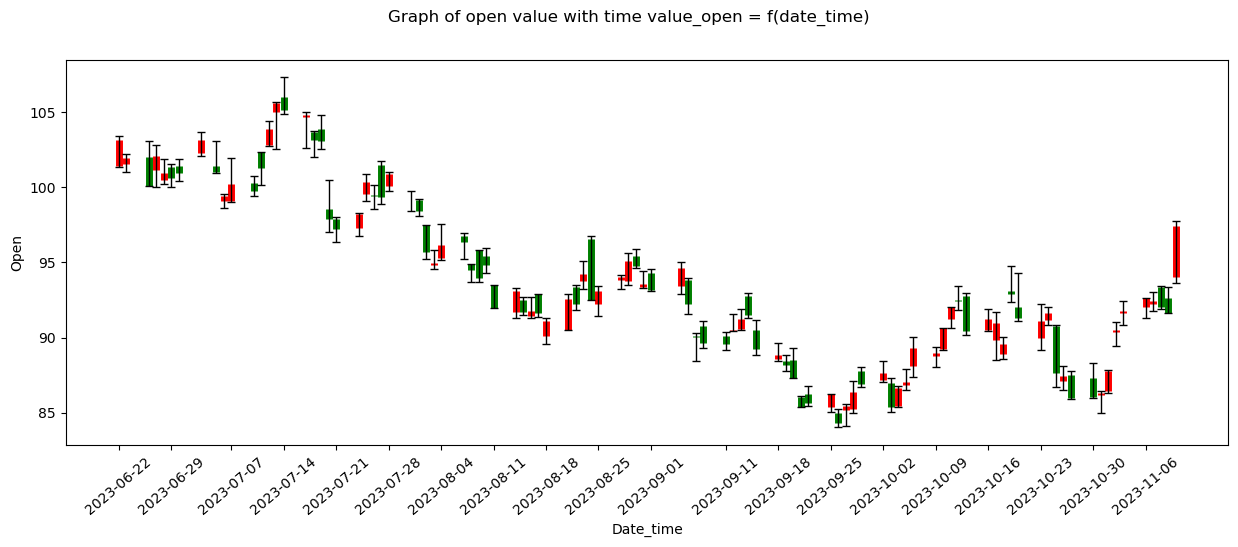

In [9]:
# Visualize data
colors = {True:'red',False:'green'}

fig, ax = plt.subplots(1,1,figsize = (15,5))
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Open"],color='g')
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Close"],color='red')
""" 
The following line of code plot bar range open close, color base on
the comparision of open price and close price
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["Y_price"],
            data_to_plot["Y_error"],
            linewidth = 5, 
            capsize=0,
            ls='none',
            ecolor = data_to_plot['IsPositive'].map(colors))
"""
The following line of code plot black interval with the width = high - low
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["HL"],
            data_to_plot["HL_error"],
            linewidth = 1,
            capsize=3,
            color='k',
            ls='none')

fig.suptitle("Graph of open value with time value_open = f(date_time)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Open")
ax.set_xticks(data_to_plot.index.tolist()[::5]) #Without this it is too dense, with this we only display every after 5 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center
plt.show()

### 0.4. Prepare data for training model:
-   We consider the Close column in our data set as timeseries data
-   Divide data into two parts:
    -   For training: first 400 rows
    -   For testing: start from row 400th

In [10]:
y_train = df_TSM["Close"][:400]
y_test = df_TSM["Close"][400:]

## 1. Task 1: Getting model from statsmodels package
### 1.1. Getting model from statsmodels:
AutoRegressive Integrated Moving Average Model is a class of statistical models for analyzing and forecasting time series data. 
The key aspects of the model are:
-   AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
-   I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
-   MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:
-   p: The number of laf observations included in the model, also called the laf order.
-   d: The number of times that the raw observations are differenced, also called the degree of differencing.
-   q: The size of the moving average window, also called the order of moving average.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

In [11]:
# Create a ARIMA model with p = 4,d = 0, q = 2 
p,d,q = (4,0,2)
arima_temp = ARIMA(y_train,order=(p,d,q))


/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

### 1.2. Training for our model

In [12]:
arima_trained = arima_temp.fit()

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
# Obtain value of parameters after training/fitting
print("Coefficients:", arima_trained.params)

Coefficients: const     93.547341
ar.L1     -0.506662
ar.L2      0.579099
ar.L3      0.927513
ar.L4     -0.029996
ma.L1      1.538592
ma.L2      0.942516
sigma2     5.063969
dtype: float64


## 2. Task 2: Evaluating the performance of trained model on the testset
### 2.1. Predict the close price for time series on the test part

In [14]:
pred_test = arima_trained.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [15]:
date_index = df_TSM.index.to_list()[400]

In [16]:
print(f"Predict Close value at time = {date_index} is:{pred_test.iloc[0]},\n true Close value is: {y_test.iloc[0]}")

Predict Close value at time = 2023-06-21 00:00:00 is:103.6170797381067,
 true Close value is: 101.63999938964844


### 2.2. Compute the metrics (quantitative measurements)

In [17]:
# R2-score:
score = r2_score(y_pred=pred_test,y_true=y_test)
print("The R2 score of our model is: ",score)

The R2 score of our model is:  -0.9912890469876607


In [18]:
# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_test,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)

The mean absolute error of our model is:  6.785690202859014


In [19]:
#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_test,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)

The root mean squared error of our model is: 7.755262392280404


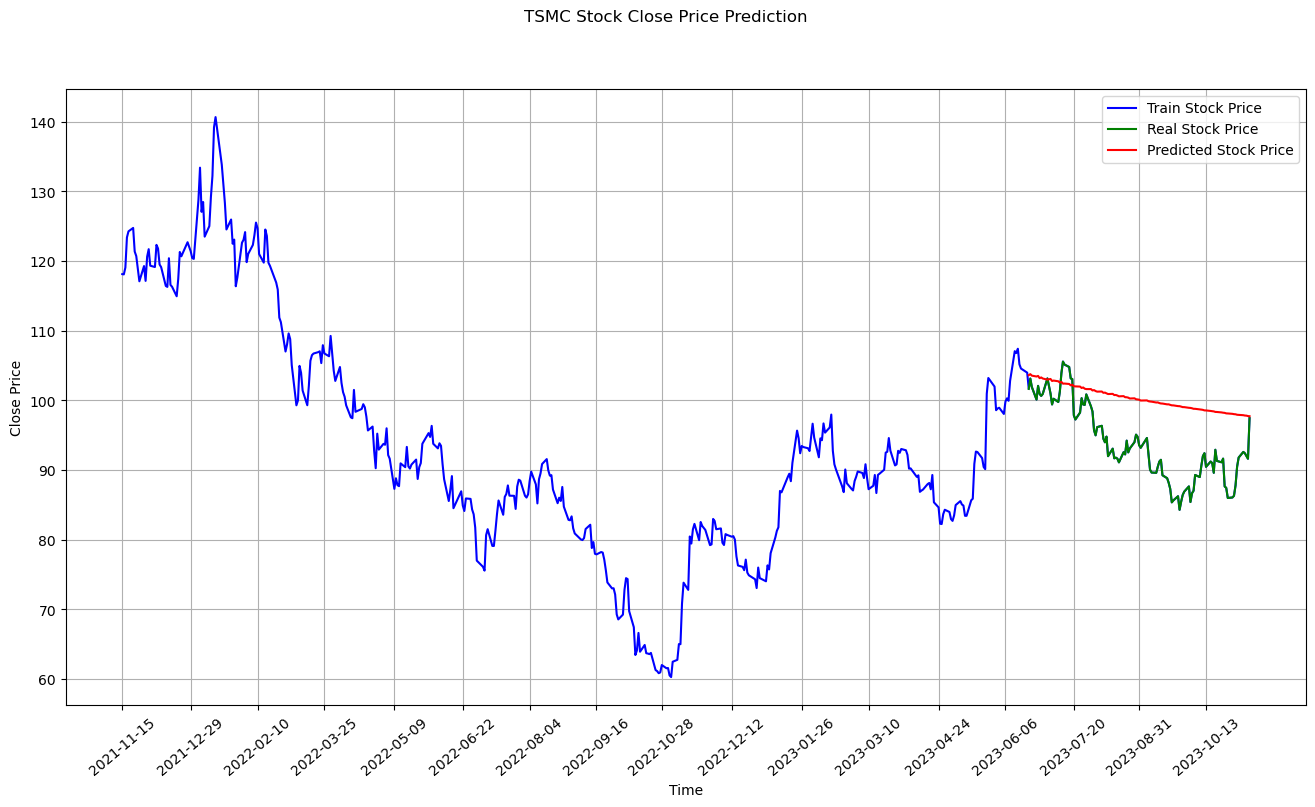

In [20]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_test, color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()

## 3. Task 3: Performing a rolling regression
A regression with a rolling time window, it means conduct regressions over and over again, with subsamples of test dataset.

In [21]:
print(y_test.iloc[0])

101.63999938964844


In [22]:
# Performing a rolling forecasts
history = [y for y in y_train]
pred_roll = []
for i in range(len(y_test)):
    # Create AR model and fit the history data to this model:
    arima_model_temp = ARIMA(history,order=(p,d,q))
    arima_trained = arima_model_temp.fit()
    # forecasts and get first forecasts (the timeseries right after history)
    y_pred = arima_trained.forecast()[0]
    # add the pred value to the list pred_roll
    pred_roll.append(y_pred)
    # update for history by appending one observation
    obs = y_test.iloc[i] # update the true close value
    history.append(obs)

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likel

In [23]:
# report performance
# R2-score:
score = r2_score(y_pred=np.array(pred_roll),y_true=np.array(y_test))
print("The R2 score of our model is: ",score)

# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_roll,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)

#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_roll,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)

The R2 score of our model is:  0.9165335939976108
The mean absolute error of our model is:  1.2113212724090991
The root mean squared error of our model is: 1.5877612575452533


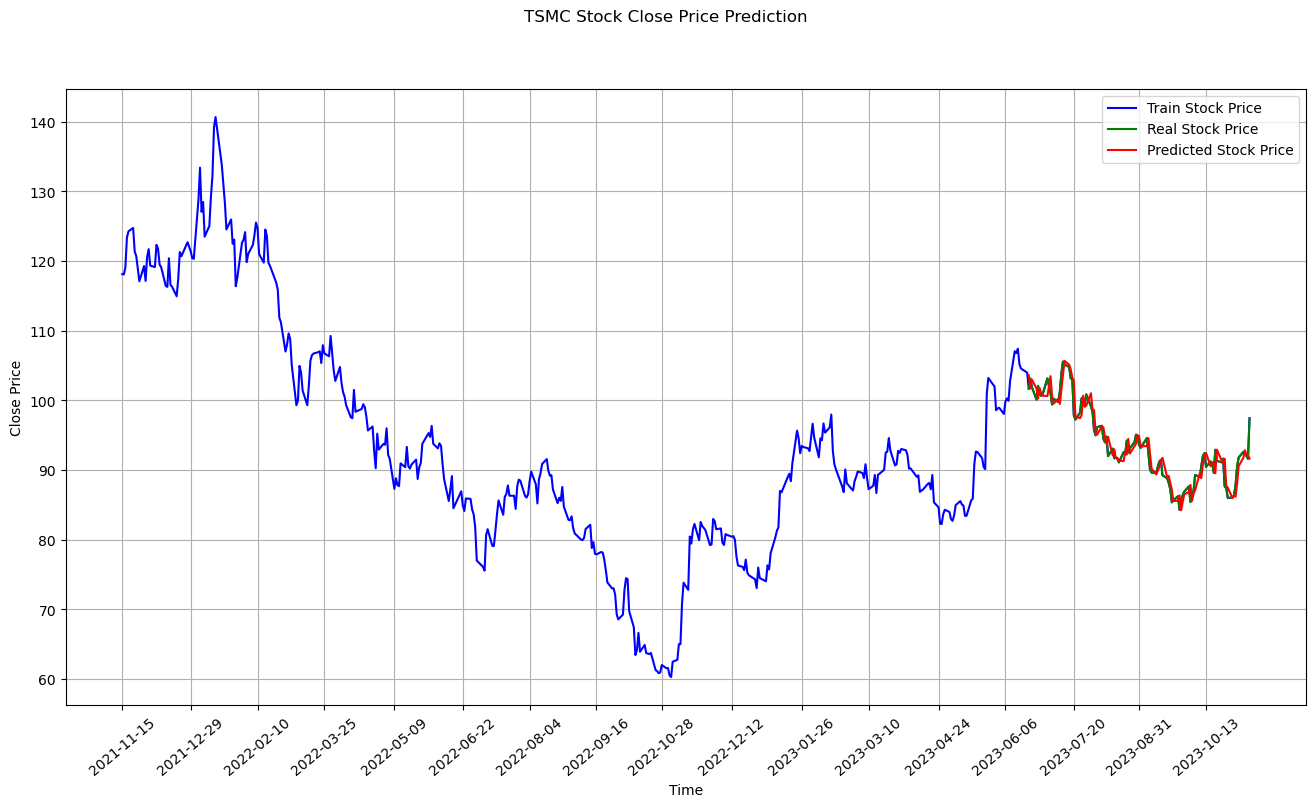

In [24]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_roll, color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()

## 4. Task 4: Considering the Autocorrelation and the Partial Autocorrelation functions:
How to choose values of p,d and q?
-   Test for stationarity using the augmented dickey fuller test.
-   If the time series is stationary try to fit the ARMA model, and if the time series is non-stationary then seek the value of d.
-   If the data is getting stationary then draw the autocorrelation and parital autocorrelation graph of the data.
-   Draw a partial autocorrelation graph (ACF) of the data. This will help us in finding the value of p because the cut-off point to the PACF is p.
-   Draw an autocorrelation graph (ACF) of the data. This will help us in finding the value of q because the cut-off point to the ACF is q.

### 4.1. Augmented Dickey-Fuller Test

In [43]:
result = adfuller(df_TSM['Close'])
print(f"ADF Statistic:{result[0]}")
print(f'p-value: {result[1]}')
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")

ADF Statistic:-2.1920297910159734
p-value: 0.20915089001829879
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


#### 4.1.a. Finding the value of the d parameter


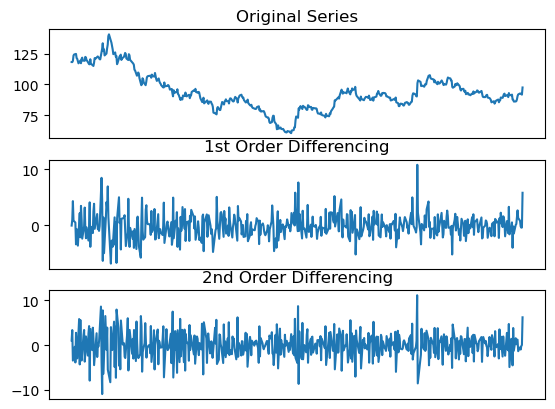

In [45]:
fig,ax = plt.subplots(3)
ax[0].plot(df_TSM['Close'])
ax[0].set_title("Original Series")
ax[0].axes.xaxis.set_visible(False)
# 1st Differencing
ax[1].plot(df_TSM["Close"].diff())
ax[1].set_title("1st Order Differencing")
ax[1].axes.xaxis.set_visible(False)
# 2nd Differencing
ax[2].plot(df_TSM["Close"].diff().diff())
ax[2].set_title("2nd Order Differencing")
ax[2].axes.xaxis.set_visible(False)

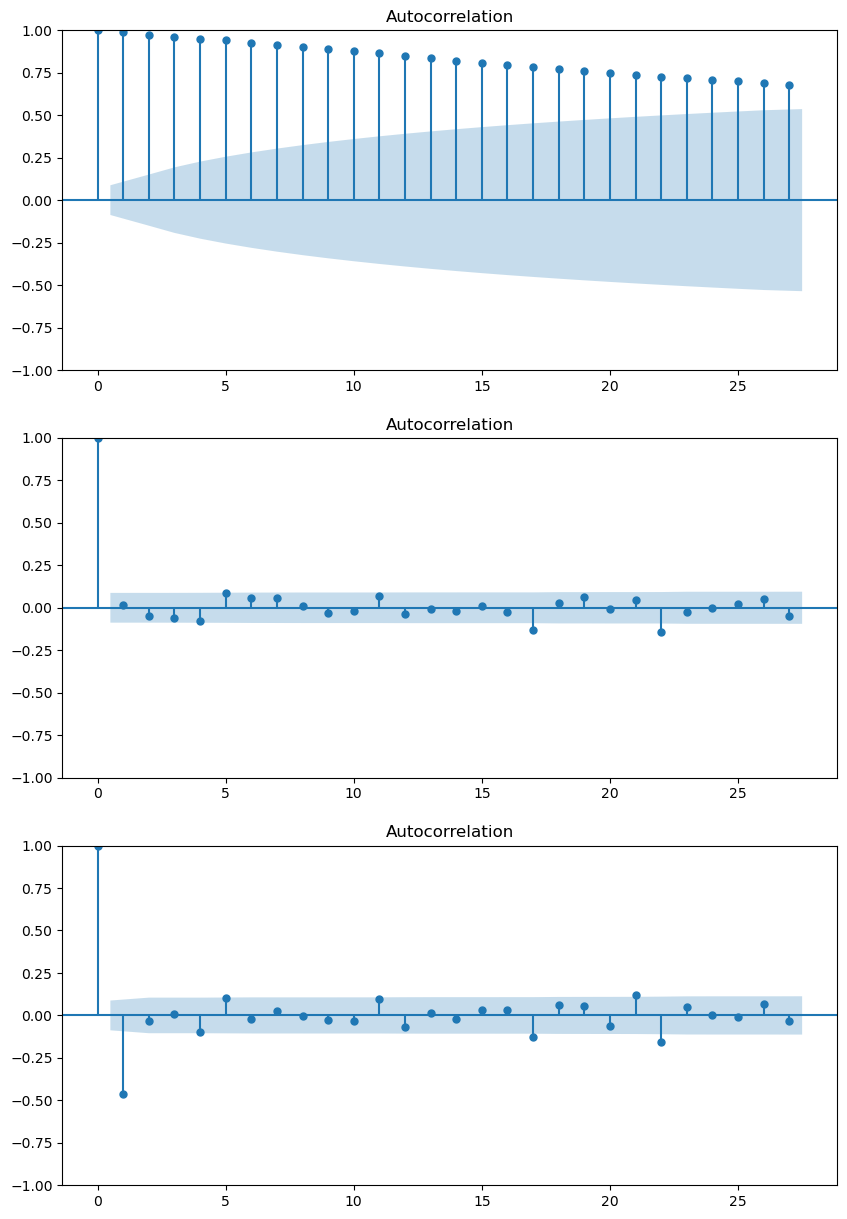

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize = (10,15))
fig = plot_acf(df_TSM['Close'], ax=ax1)
fig = plot_acf(df_TSM['Close'].diff().dropna(), ax=ax2)
fig = plot_acf(df_TSM['Close'].diff().diff().dropna(), ax=ax3)


#### 4.1.b. Finding the value of the p parameter

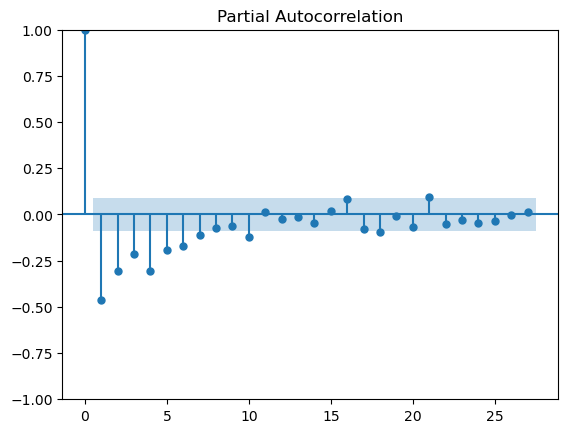

In [57]:
fig = plot_pacf(df_TSM['Close'].diff().diff().dropna())

#### 4.1.c. Finding the value of the q parameter

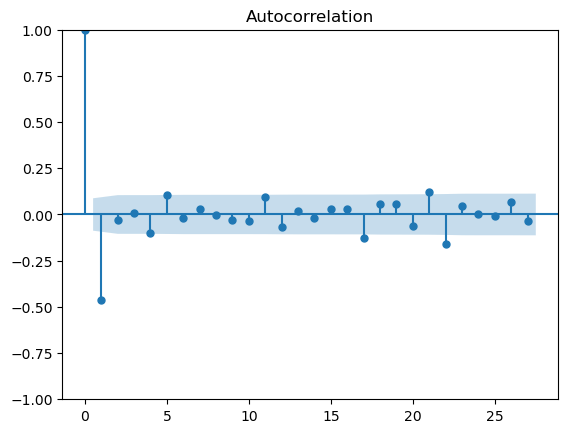

In [58]:
fig = plot_acf(df_TSM['Close'].diff().diff().dropna())

### 4.2. Plot acf and pacf depends on lags


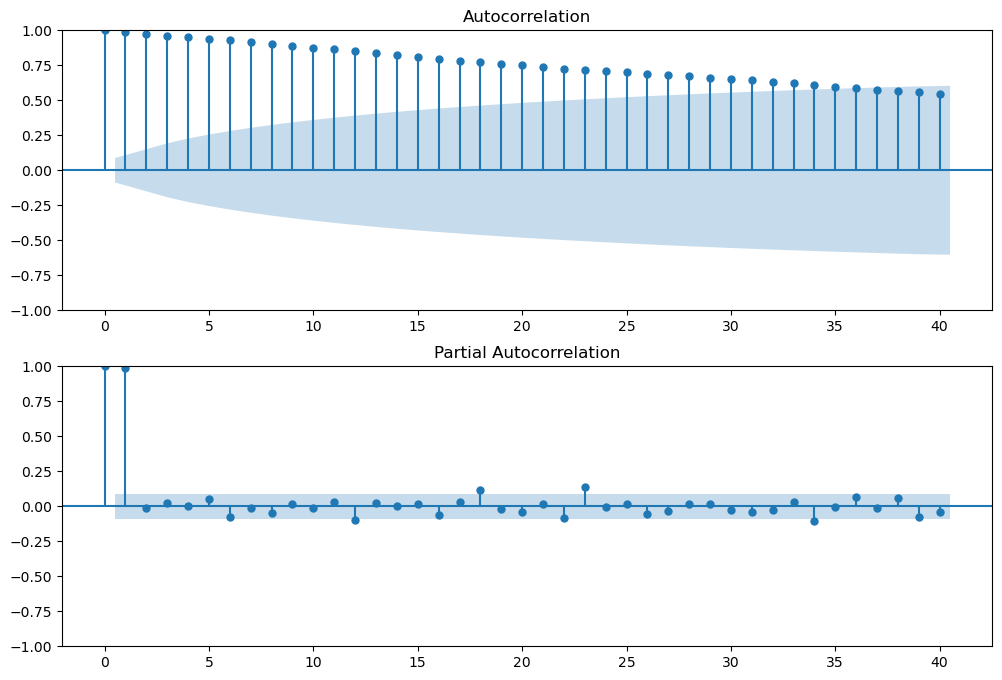

In [27]:
fig,ax = plt.subplots(2,1,figsize = (12,8))
fig = sm.graphics.tsa.plot_acf(df_TSM['Close'],lags = 40, ax = ax[0])
fig = sm.graphics.tsa.plot_pacf(df_TSM['Close'],lags = 40, ax = ax[1])

In [37]:
r_list, q_list, p_list = sm.tsa.acf(y_train.values.squeeze(), fft=True, qstat=True)


In [38]:
print(len(r_list),len(q_list),len(p_list))

27 26 26


In [39]:
data = np.c_[np.arange(1, 27), r_list[1:], q_list, p_list]

In [40]:
table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
print(table.set_index("lag"))

            AC            Q       Prob(>Q)
lag                                       
1.0   0.987710   393.162078   1.696274e-87
2.0   0.974873   777.133987  1.768067e-169
3.0   0.962820  1152.613232  1.400796e-249
4.0   0.950870  1519.754643   0.000000e+00
5.0   0.940187  1879.601301   0.000000e+00
6.0   0.927459  2230.659977   0.000000e+00
7.0   0.914387  2572.760499   0.000000e+00
8.0   0.900703  2905.544777   0.000000e+00
9.0   0.887575  3229.525819   0.000000e+00
10.0  0.874937  3545.153661   0.000000e+00
11.0  0.863246  3853.192602   0.000000e+00
12.0  0.849303  4152.129760   0.000000e+00
13.0  0.835473  4442.158019   0.000000e+00
14.0  0.822185  4723.761555   0.000000e+00
15.0  0.808883  4997.034224   0.000000e+00
16.0  0.794212  5261.170256   0.000000e+00
17.0  0.780481  5516.918049   0.000000e+00
18.0  0.770663  5766.924856   0.000000e+00
19.0  0.760828  6011.230945   0.000000e+00
20.0  0.750020  6249.269894   0.000000e+00
21.0  0.739297  6481.161141   0.000000e+00
22.0  0.727

## Task 2.2: Create an Autoregressive Moving Average model

Autoregressive Integrated Moving Average (ARIMA) model, and extensions

This model is the basic interface for ARIMA-type models, including those with exogenous regressors and those with seasonal components. The most general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows all specialized cases, including

-   autoregressive models: AR(p)

-   moving average models: MA(q)

-   mixed autoregressive moving average models: ARMA(p, q)

-   integration models: ARIMA(p, d, q)

-   seasonal models: SARIMA(P, D, Q, s)

-   regression with errors that follow one of the above ARIMA-type models

[https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html](Documents of statsmodels.tsa.arima.model.ARIMA)

In [5]:
# import package
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [6]:
# Prepare data for model
y_train = df_BMW["Close"][:1000]
y_test = df_BMW["Close"][1000:]
print(len(y_test))

266


In [7]:
# Create an autoregressive moving average model
p,d,q = (2,0,2)
temp_arma = ARIMA(y_train,order=(p,d,q))
trained_arma = temp_arma.fit()

In [8]:
# Obtain value of parameters after training/fitting
print("Coefficients:", trained_arma.params)

Coefficients: const     73.239064
ar.L1      1.387316
ar.L2     -0.390465
ma.L1     -0.338936
ma.L2      0.035043
sigma2     1.166061
dtype: float64


## Notice:

Take a look at slide of Auto-Regressive Moving Average of lecture ppt:
-   Consider the function form of ARMA:
    -   In previous demo of code we are using p = 2, q = 2 (d=0, without intergrated)
    -   After fitting model we obtain trained model with Autoregressive parameters (ar.L1 and ar.L2 denoted as $\phi _i $ in the slide) and (Moving average parameters denoted as $\theta _j$ in the slide)$$

In [9]:
# Use trained/fitted model to predict close value on last 266 times (test times)
y_pred = trained_arma.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)


In [10]:
print(f"Predict Close value at time = {df_BMW['Date'][1000]} is:{y_pred[1000]}, true Close value is: {df_BMW['Close'][1000]}")

Predict Close value at time = 2020-08-03 is:54.569680117295675, true Close value is: 56.209999


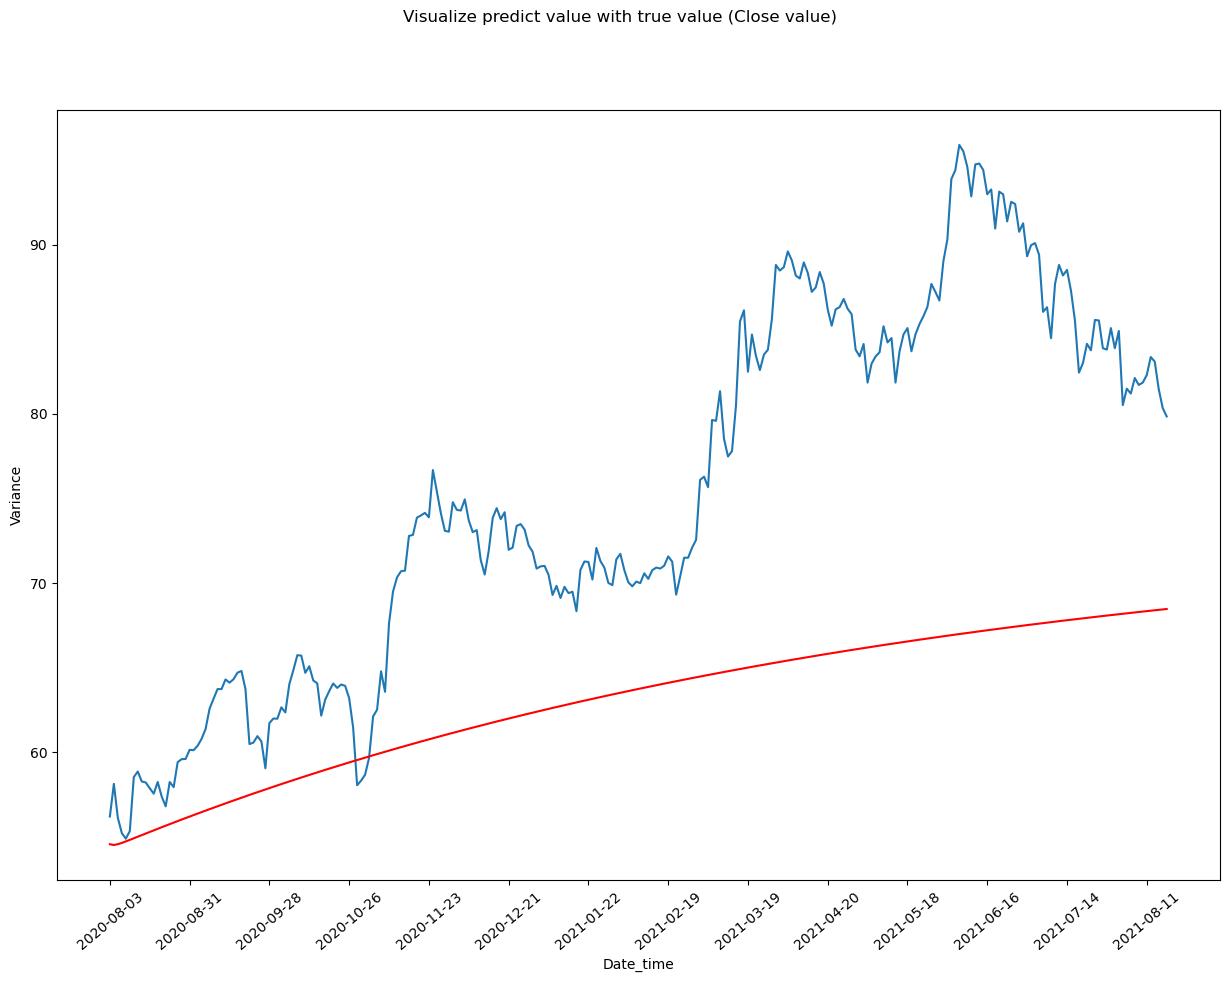

In [11]:
# Visualize predict value with true value
fig, ax = plt.subplots(1,1,figsize = (15,10))
ax.plot(df_BMW["Date"][1000:],y_test)
ax.plot(df_BMW["Date"][1000:],y_pred,color = 'red')
fig.suptitle("Visualize predict value with true value (Close value)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Variance")
ax.set_xticks(ax.get_xticks()[::20])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')
plt.show()

In [12]:
# Mean squared error:
from math import sqrt
print("Square root of MSE on test dataset:",sqrt(mean_squared_error(y_pred=y_pred.to_numpy(),y_true=y_test.to_numpy())))

Square root of MSE on test dataset: 14.379513705018045


In [13]:
## One more template model with p = 13, q = 9
# Create an autoregressive moving average model
p,d,q = (13,0,9)
temp_ar13ma9 = ARIMA(y_train,order=(p,d,q))
trained_ar13ma9 = temp_ar13ma9.fit()

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Obtain value of parameters after training/fitting
# print("Coefficients:", trained_ar30ma10.params)

In [15]:
print(trained_ar13ma9.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1000
Model:                ARIMA(13, 0, 9)   Log Likelihood               -1487.783
Date:                Wed, 01 Nov 2023   AIC                           3023.567
Time:                        17:51:44   BIC                           3141.353
Sample:                             0   HQIC                          3068.333
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.7980      8.564      8.851      0.000      59.013      92.583
ar.L1         -0.3038      3.662     -0.083      0.934      -7.481       6.873
ar.L2         -0.1893      3.321     -0.057      0.9

In [16]:
# Use trained/fitted model to predict close value on last 266 times (test times)
y_pred13_9 = trained_ar13ma9.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)

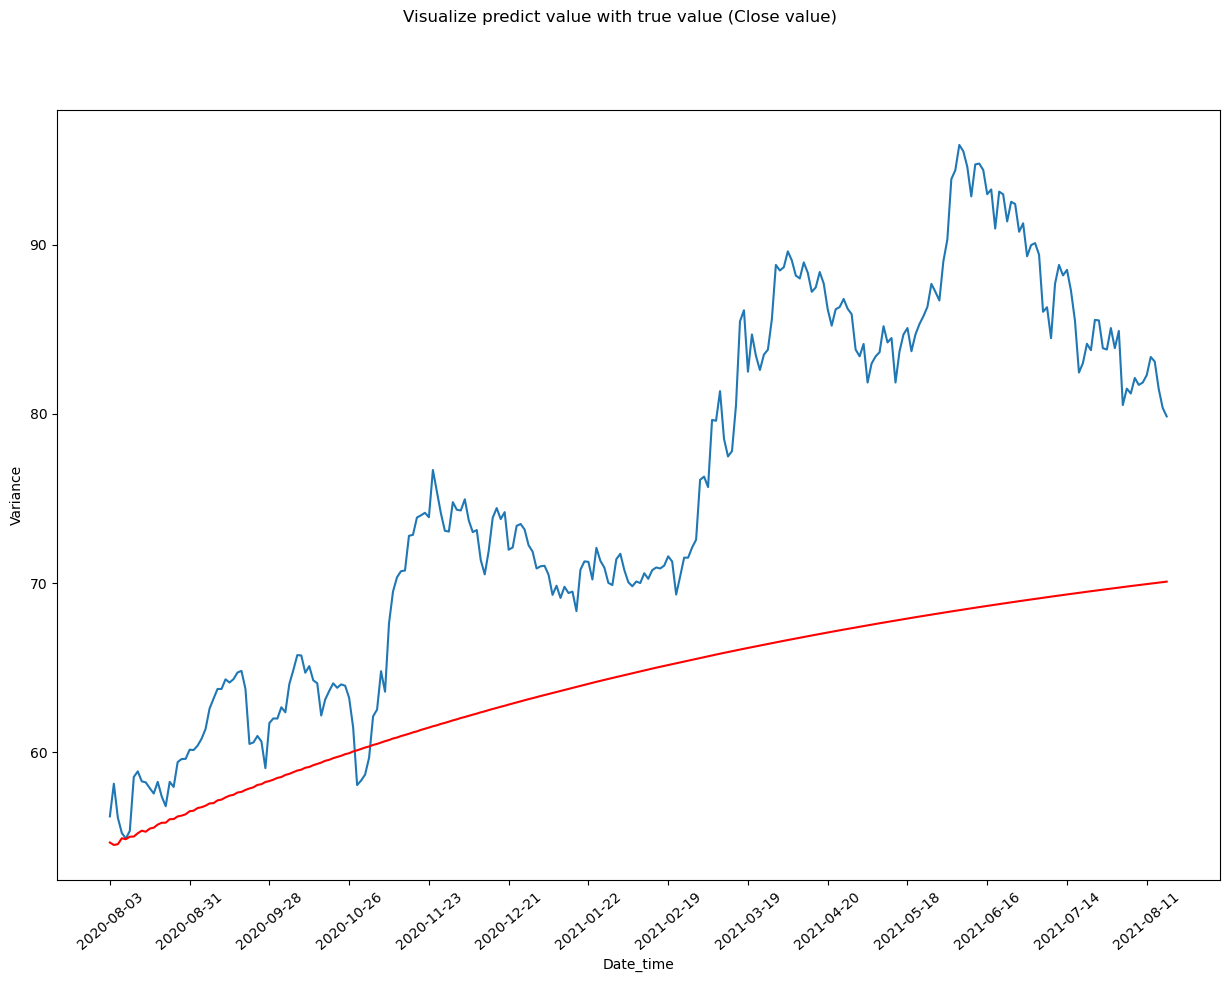

In [17]:
# Visualize predict value with true value
fig, ax = plt.subplots(1,1,figsize = (15,10))
ax.plot(df_BMW["Date"][1000:],y_test)
ax.plot(df_BMW["Date"][1000:],y_pred13_9,color = 'red')
fig.suptitle("Visualize predict value with true value (Close value)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Variance")
ax.set_xticks(ax.get_xticks()[::20])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')
plt.show()

In [18]:
# Mean squared error:
from math import sqrt
print("Square root of MSE on test dataset:",sqrt(mean_squared_error(y_pred=y_pred13_9.to_numpy(),y_true=y_test.to_numpy())))

Square root of MSE on test dataset: 13.384371289751904


## Task 2.3: Auto-Regressive Integrated Moving Average model

In [19]:
p,d,q = (5,2,3)
temp_arima = ARIMA(y_train,order=(p,d,q))
trained_arima = temp_arima.fit()

In [20]:
# Obtain value of parameters after training/fitting
print("Coefficients:", trained_arima.params)

Coefficients: ar.L1    -1.531748
ar.L2    -0.765727
ar.L3     0.157462
ar.L4     0.100045
ar.L5     0.061814
ma.L1     0.596312
ma.L2    -0.694368
ma.L3    -0.900595
sigma2    1.152207
dtype: float64


In [21]:
print(trained_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1000
Model:                 ARIMA(5, 2, 3)   Log Likelihood               -1490.016
Date:                Wed, 01 Nov 2023   AIC                           2998.032
Time:                        17:51:46   BIC                           3042.184
Sample:                             0   HQIC                          3014.814
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5317      0.055    -28.049      0.000      -1.639      -1.425
ar.L2         -0.7657      0.068    -11.299      0.000      -0.899      -0.633
ar.L3          0.1575      0.060      2.645      0.0

In [22]:
# Use trained/fitted model to predict close value on last 266 times (test times)
y_pred_arima = trained_arima.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)

In [23]:
df_BMW.index

RangeIndex(start=0, stop=1266, step=1)

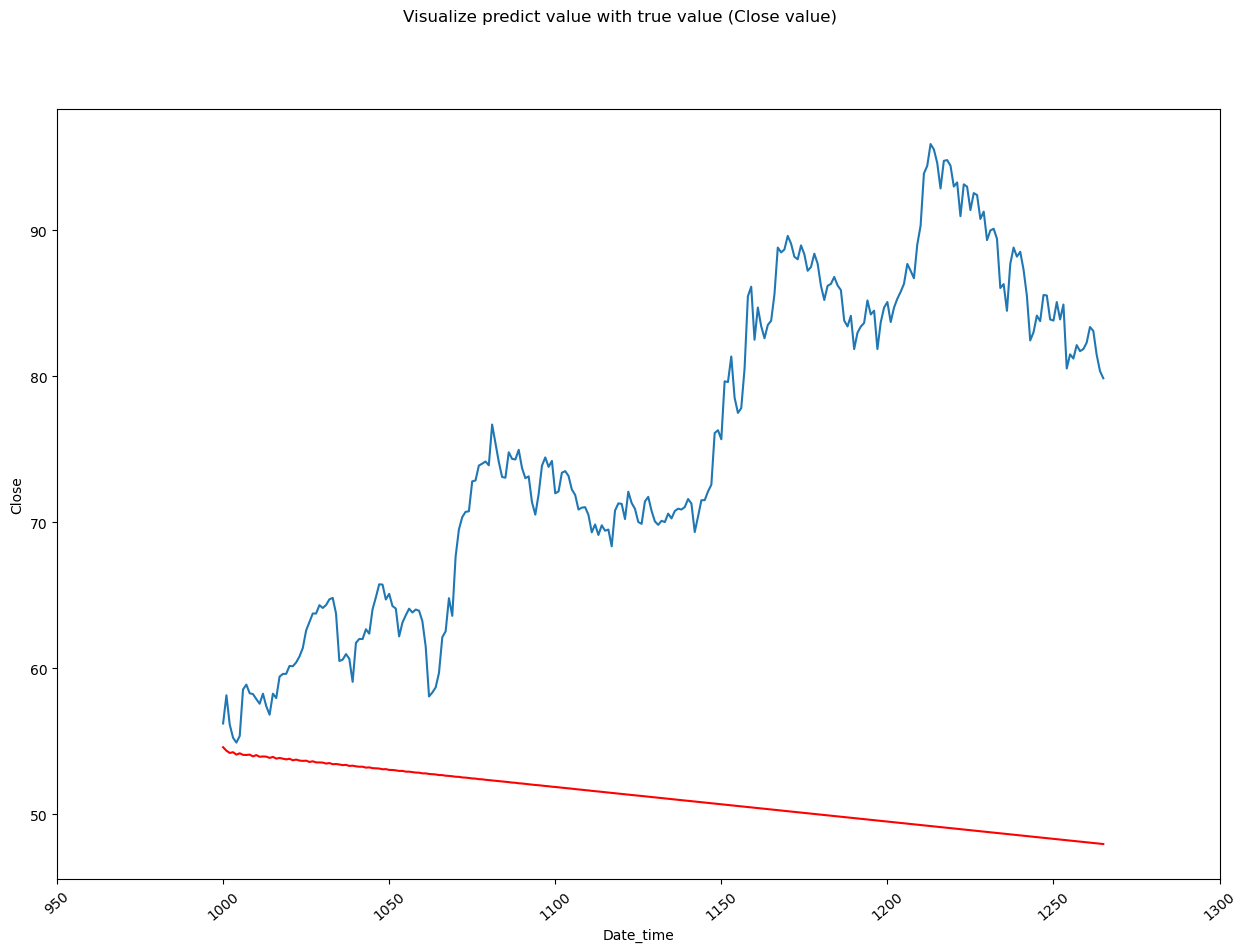

In [24]:
# Visualize predict value with true value
fig, ax = plt.subplots(1,1,figsize = (15,10))
ax.plot(df_BMW.index[1000:],y_test)
ax.plot(df_BMW.index[1000:],y_pred_arima,color = 'red')
fig.suptitle("Visualize predict value with true value (Close value)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Close")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')
plt.show()

In [25]:
# Mean squared error:
print("Square root of MSE on test dataset:",sqrt(mean_squared_error(y_pred=y_pred_arima.to_numpy(),y_true=y_test.to_numpy())))

Square root of MSE on test dataset: 27.274829990029485


### Task 3: Using the adf test to choose the order p,d,q
-   Take a look at Demo_0 we choose two model to visualize evaluation of peredict (forecat)

In [26]:
# Model ARIMA(57,1,57)
df_BMW["Date"] = pd.to_datetime(df_BMW["Date"])
df_BMW = df_BMW.set_index("Date")

In [27]:
model_1 = ARIMA(df_BMW['Close'],order = (57,1,57))
model_1_fit = model_1.fit()
# model_1_fit.summary()

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
# Use trained/fitted model to predict close value on last 266 times (test times)
y_pred_model1 = model_1_fit.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)

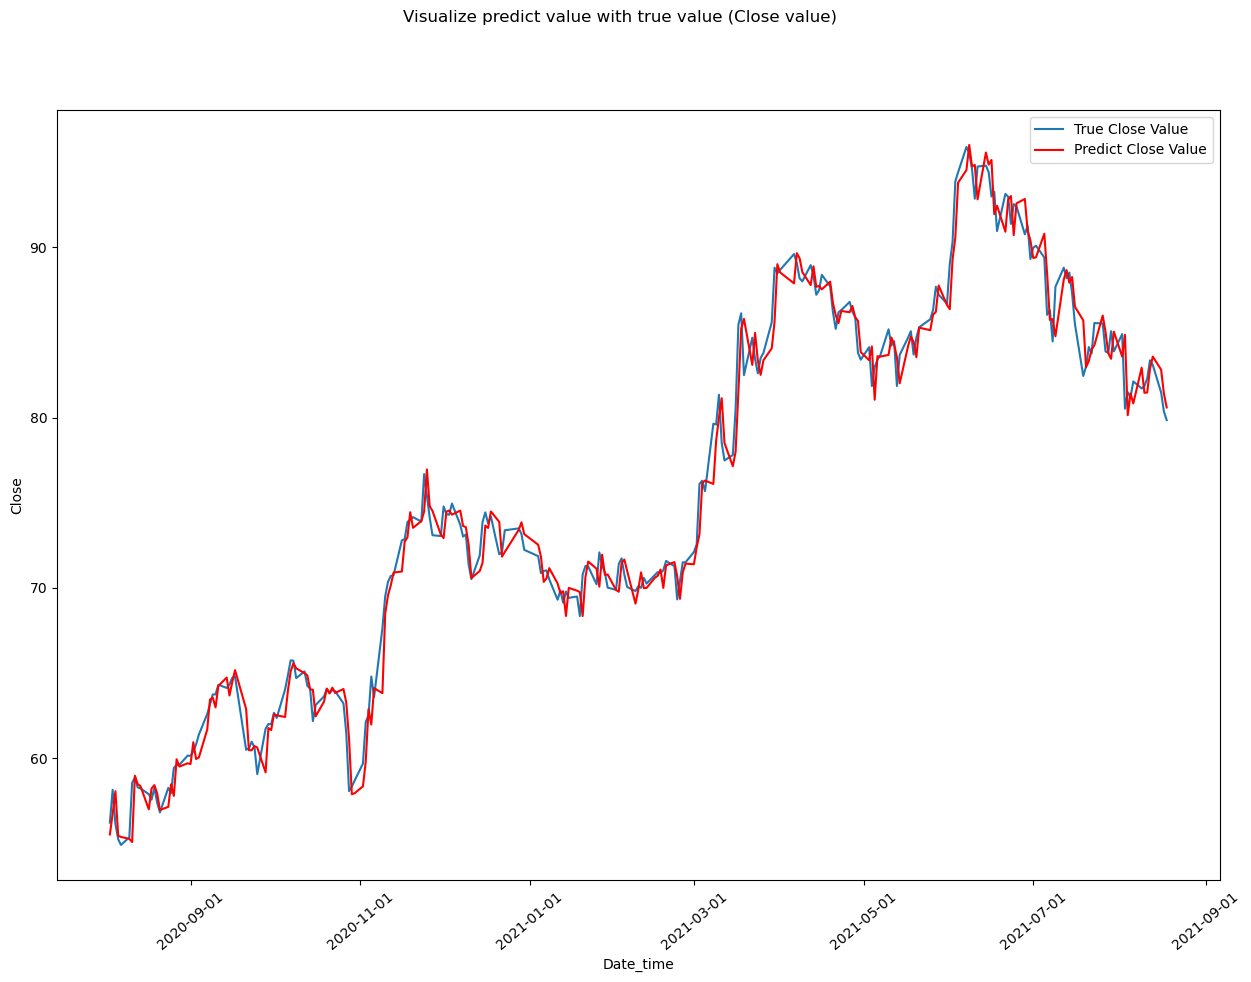

In [29]:
# Visualize predict value with true value
fig, ax = plt.subplots(1,1,figsize = (15,10))
ax.plot(df_BMW.index[1000:],y_test,label = 'True Close Value')
ax.plot(df_BMW.index[1000:],y_pred_model1,color = 'red', label = "Predict Close Value")
fig.suptitle("Visualize predict value with true value (Close value)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Close")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')
ax.legend()
plt.show()

In [30]:
# Mean squared error:
print("Square root of MSE on test dataset:",sqrt(mean_squared_error(y_pred=y_pred_model1.to_numpy(),y_true=y_test.to_numpy())))

Square root of MSE on test dataset: 1.2513480803080497


In [31]:
model_2 = ARIMA(df_BMW['Close'],order = (1,2,1))
model_2_fit = model_2.fit()
model_2_fit.summary()

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1266
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1962.599
Date:                Wed, 01 Nov 2023   AIC                           3931.198
Time:                        18:00:34   BIC                           3946.624
Sample:                             0   HQIC                          3936.994
                               - 1266                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0414      0.027      1.559      0.119      -0.011       0.094
ma.L1         -0.9998      0.020    -49.834      0.000      -1.039      -0.960
sigma2         1.2996      0.037     34.764      0.000       1.226       1.373
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               733.42
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.68   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Use trained/fitted model to predict close value on last 266 times (test times)
y_pred_model2 = model_2_fit.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)

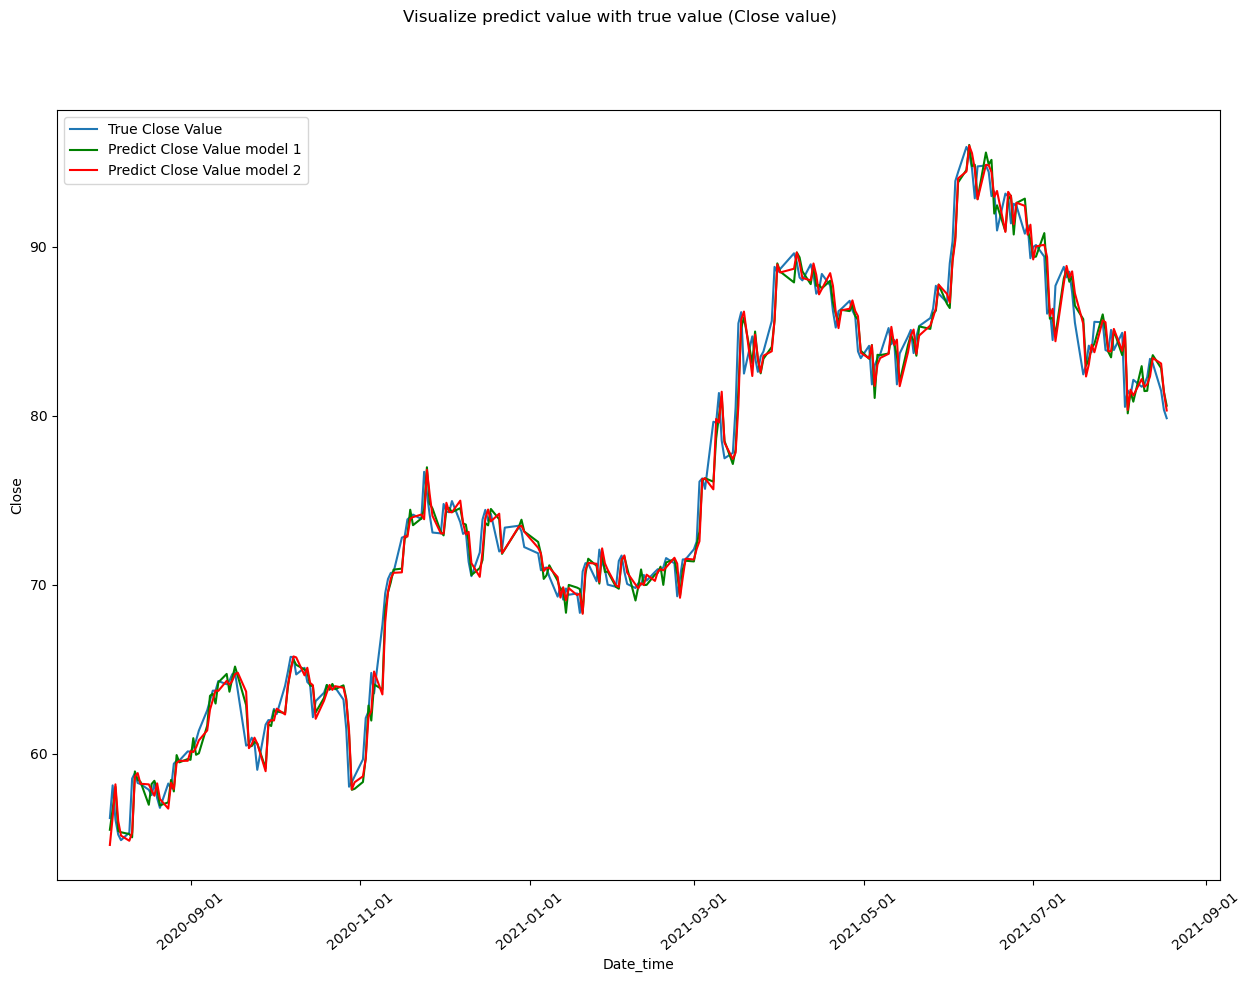

In [33]:
# Visualize predict value with true value
fig, ax = plt.subplots(1,1,figsize = (15,10))
ax.plot(df_BMW.index[1000:],y_test,label = 'True Close Value')
ax.plot(df_BMW.index[1000:],y_pred_model1,color = 'green', label = "Predict Close Value model 1")

ax.plot(df_BMW.index[1000:],y_pred_model2,color = 'red', label = "Predict Close Value model 2")

fig.suptitle("Visualize predict value with true value (Close value)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Close")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')
ax.legend()
plt.show()

In [34]:
# Mean squared error:
print("Square root of MSE on test dataset:",sqrt(mean_squared_error(y_pred=y_pred_model2.to_numpy(),y_true=y_test.to_numpy())))

Square root of MSE on test dataset: 1.3325168099978633


In [35]:
df_BMW.index[1000]

Timestamp('2020-08-03 00:00:00')

In [36]:
train_data,test_data = df_BMW[:1000],df_BMW[1000:]
train_arima = train_data['Close']
test_arima = test_data['Close']

In [37]:
test_arima

Date
2020-08-03    56.209999
2020-08-04    58.139999
2020-08-05    56.130001
2020-08-06    55.230000
2020-08-07    54.900002
                ...    
2021-08-12    83.360001
2021-08-13    83.089996
2021-08-16    81.470001
2021-08-17    80.349998
2021-08-18    79.849998
Name: Close, Length: 266, dtype: float64

In [38]:
history = [x for x in train_arima]
y = test_arima
predictions = []
model = ARIMA(history, order=(1,2,1))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

/var/folders/pr/m0clhjz90k976cml329f7j740000gn/T/ipykernel_69806/2942003314.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(y[0])


In [39]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,2,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

/var/folders/pr/m0clhjz90k976cml329f7j740000gn/T/ipykernel_69806/3486448204.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = y[i]


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
# report performance
mse = mean_squared_error(np.array(y), np.array(predictions))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.array(y),np.array( predictions))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.array(y), np.array(predictions)))
print('RMSE: '+str(rmse))

MSE: 1.7803907967311248
MAE: 0.9752450482965197
RMSE: 1.3343128556418562


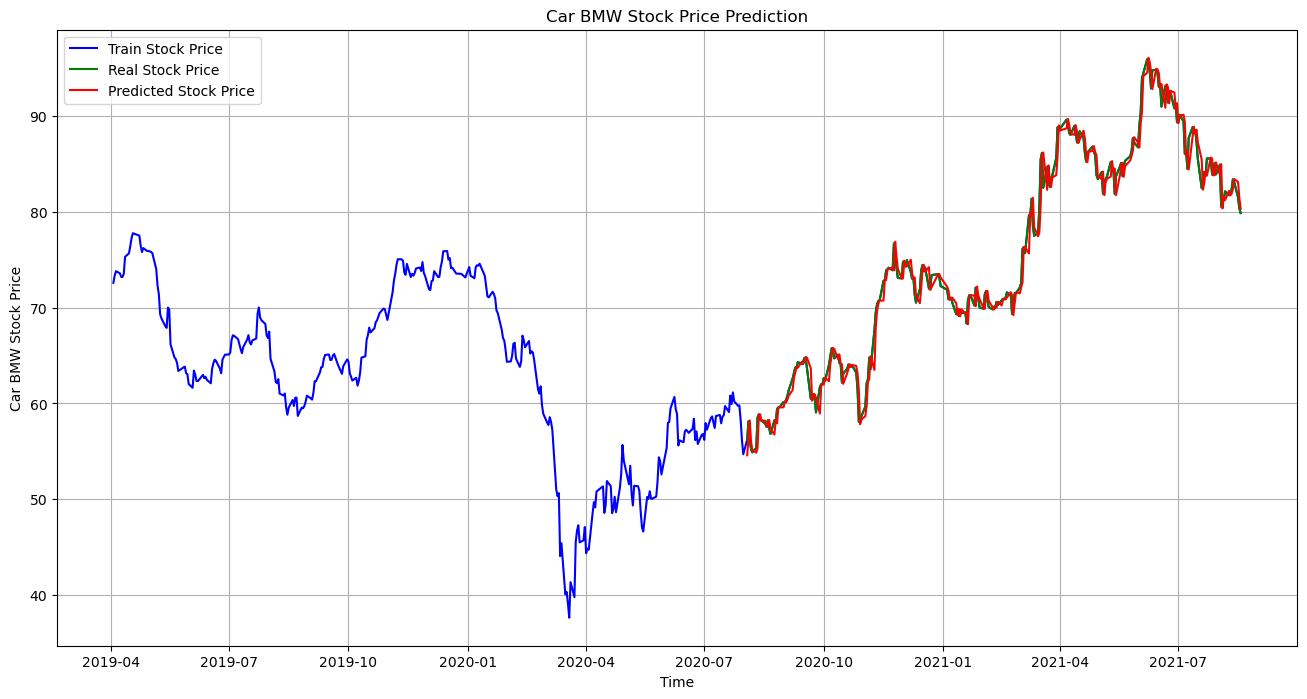

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(df_BMW.index[-600:], df_BMW['Close'].tail(600), color='blue', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'green', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'red', label = 'Predicted Stock Price')
plt.title('Car BMW Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Car BMW Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()